# Reaction-diffusion system

Reaction diffusion system exhibiting sprial waves on a periodic domain.  We derive PDE's for each of two quantities, having dependancies on each other; $u$ and $v$.  

\begin{align*}
u_t &= 0.1\nabla^2 u + \lambda(A)u - \omega(A)v\\
v_t &= 0.1\nabla^2 v + \omega(A)u + \lambda(A)v\\
A^2 &= u^2 + v^2,\, \omega(A) = -\beta A^2, \lambda(A) = 1-A^2
\end{align*}

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('./reaction_diffusion_big.mat')

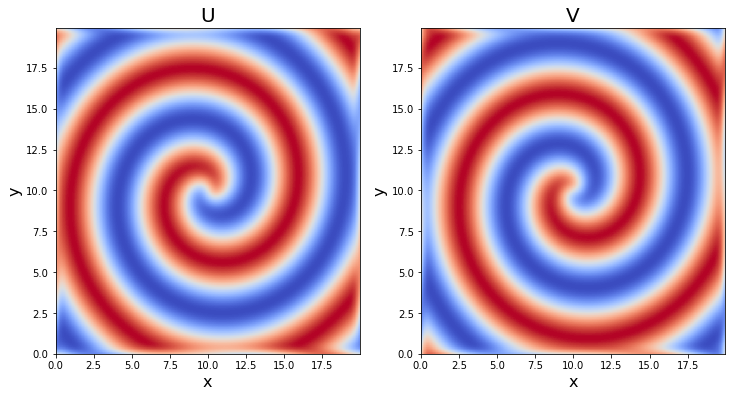

In [3]:
t = data['t'][:,0]
x = data['x'][0,:]
y = data['y'][0,:]
U = data['u']
V = data['v']
t = t[:180]
U_original = np.copy(U)
V_original = np.copy(V)
U = U[:,:,:180]
V = V[:,:,:180]


n = len(x) # also the length of y
steps = len(t)
dx = x[2]-x[1]
dy = y[2]-y[1]
dt = t[2]-t[1]

pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(1,2,1)
pcolor(xx,yy,U[:,:,10],cmap='coolwarm')
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
pcolor(xx,yy,V[:,:,10],cmap='coolwarm')
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

Plotting V for different time step.

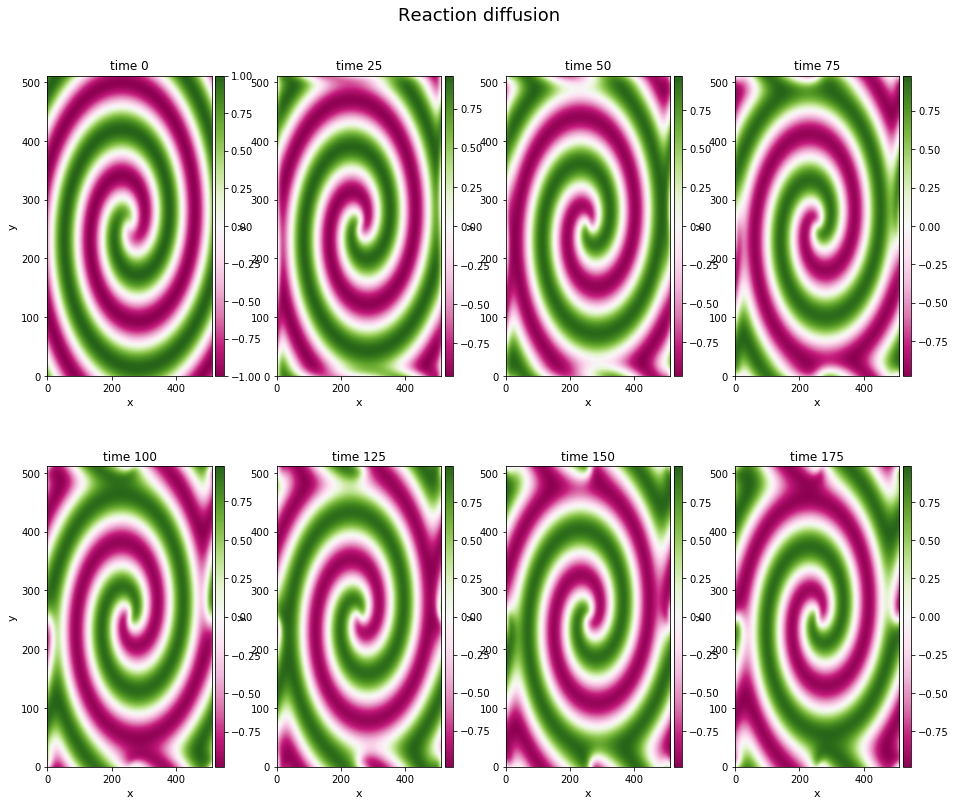

In [4]:

fig = plt.figure(figsize=(15, 12))
fig.suptitle("Reaction diffusion", fontsize=18)
gs = gridspec.GridSpec(2, 4)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)   
k = -1
j = 0


for _time in np.arange(0, 180, 25):

    if j % 4 == 0:
        k += 1
        
    ax = plt.subplot(gs[k, j%4])
    h = ax.imshow(V[:, :, _time], interpolation='lanczos', cmap='PiYG', 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % _time, fontsize = 12)
    
    j += 1

# SVD reduction

Evaluating the SVD to considering the singular values contribute in the data.

In [5]:
matrix_dim = V.shape[0] 
n_test_time = int(steps * dt)
V_flat = np.reshape(V, (matrix_dim ** 2, steps))

X = np.copy(V_flat)
U_svd, S_svd, Vh_svd = np.linalg.svd(X, full_matrices=False) #S_svd singular values
V_svd = Vh_svd.conj().T

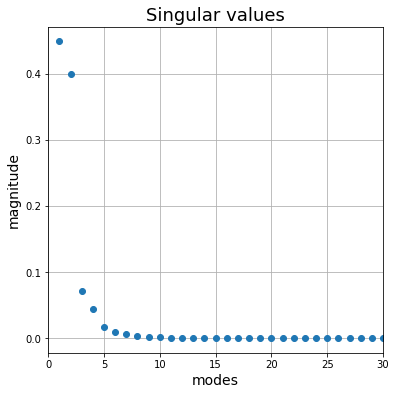

In [6]:
fig = plt.figure(figsize=(6, 6))
plt.plot(range(1,len(S_svd)+1), S_svd / np.sum(S_svd), 'o', linewidth='2')
plt.title('Singular values', fontsize = 18)
plt.xlabel("modes", fontsize=14)
plt.ylabel("magnitude", fontsize=14)
plt.xlim([0, 30])
plt.grid()

Starting considering the first 6 modes. Going to evaluate the contribute of the first 6 modes (98.6%).

In [7]:
reduced_rank = 6
reduced_energy_ratio = np.sum(S_svd[:reduced_rank]) / np.sum(S_svd)
print(reduced_energy_ratio)

0.988667212106436


In [8]:
Ur_svd = U_svd[:, :reduced_rank]
Vr_svd = V_svd[:, :reduced_rank]
Sr_svd = S_svd[:reduced_rank]

X_reduced = np.matmul(Ur_svd.conj().T,X)

Taking data for traning. NN model will be created. 

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, n):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n, n*10),
            nn.ReLU(),
            nn.Linear(n*10, n*5),
            nn.ReLU(),
            nn.Linear(n*5, n*10),
            nn.ReLU(),
            nn.Linear(n*10, n),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(reduced_rank).to("cpu")
model.double()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=6, bias=True)
  )
)

Splitting for training and test data.

In [10]:
u_train, u_test, y_train, y_test = train_test_split(X_reduced[:,:-1].T, X_reduced[:,1:].T,  test_size=0.2, random_state=113)

batch = 32
learning_rate = 1e-4
epochs = 1000

tu_train = torch.from_numpy(u_train)
ty_train = torch.from_numpy(y_train)
tu_test = torch.from_numpy(u_test)
ty_test = torch.from_numpy(y_test)

print(tu_train.shape)

train_dataset = torch.utils.data.TensorDataset(tu_train, ty_train)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(tu_test, ty_test)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)

torch.Size([143, 6])


In [11]:
loss_fn = nn.MSELoss() # questa potrebbe funzionare per regressione
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        optimizer.step()

            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += np.sqrt((np.power(pred - y,2).sum())/len(y))

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Root Means Square Error: {(100*correct):>0.1f}, Avg loss: {test_loss:>8f} \n")
            
for tt in range(epochs):
    print(f"Epoch {tt+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    


Epoch 1
-------------------------------
Test Error: 
 Root Means Square Error: 1899.9, Avg loss: 19492.629210 

Epoch 2
-------------------------------
Test Error: 
 Root Means Square Error: 1894.7, Avg loss: 19384.777158 

Epoch 3
-------------------------------
Test Error: 
 Root Means Square Error: 1889.5, Avg loss: 19280.257348 

Epoch 4
-------------------------------
Test Error: 
 Root Means Square Error: 1884.3, Avg loss: 19173.010041 

Epoch 5
-------------------------------
Test Error: 
 Root Means Square Error: 1879.0, Avg loss: 19065.735629 

Epoch 6
-------------------------------
Test Error: 
 Root Means Square Error: 1873.8, Avg loss: 18959.272981 

Epoch 7
-------------------------------
Test Error: 
 Root Means Square Error: 1868.5, Avg loss: 18852.413878 

Epoch 8
-------------------------------
Test Error: 
 Root Means Square Error: 1863.0, Avg loss: 18742.107720 

Epoch 9
-------------------------------
Test Error: 
 Root Means Square Error: 1857.4, Avg loss: 18629.2

Test Error: 
 Root Means Square Error: 541.2, Avg loss: 1584.990516 

Epoch 86
-------------------------------
Test Error: 
 Root Means Square Error: 521.5, Avg loss: 1471.261376 

Epoch 87
-------------------------------
Test Error: 
 Root Means Square Error: 502.5, Avg loss: 1365.354837 

Epoch 88
-------------------------------
Test Error: 
 Root Means Square Error: 483.8, Avg loss: 1265.568344 

Epoch 89
-------------------------------
Test Error: 
 Root Means Square Error: 465.7, Avg loss: 1172.413231 

Epoch 90
-------------------------------
Test Error: 
 Root Means Square Error: 447.8, Avg loss: 1083.578824 

Epoch 91
-------------------------------
Test Error: 
 Root Means Square Error: 431.2, Avg loss: 1004.539890 

Epoch 92
-------------------------------
Test Error: 
 Root Means Square Error: 415.3, Avg loss: 931.691775 

Epoch 93
-------------------------------
Test Error: 
 Root Means Square Error: 400.6, Avg loss: 866.532679 

Epoch 94
-------------------------------
Tes

Test Error: 
 Root Means Square Error: 243.4, Avg loss: 325.321746 

Epoch 171
-------------------------------
Test Error: 
 Root Means Square Error: 243.3, Avg loss: 325.264304 

Epoch 172
-------------------------------
Test Error: 
 Root Means Square Error: 243.4, Avg loss: 325.618566 

Epoch 173
-------------------------------
Test Error: 
 Root Means Square Error: 243.2, Avg loss: 325.064248 

Epoch 174
-------------------------------
Test Error: 
 Root Means Square Error: 243.0, Avg loss: 324.371857 

Epoch 175
-------------------------------
Test Error: 
 Root Means Square Error: 242.9, Avg loss: 324.001833 

Epoch 176
-------------------------------
Test Error: 
 Root Means Square Error: 242.6, Avg loss: 323.263491 

Epoch 177
-------------------------------
Test Error: 
 Root Means Square Error: 242.3, Avg loss: 322.283614 

Epoch 178
-------------------------------
Test Error: 
 Root Means Square Error: 242.1, Avg loss: 321.578320 

Epoch 179
-------------------------------
T

Test Error: 
 Root Means Square Error: 211.0, Avg loss: 243.986567 

Epoch 254
-------------------------------
Test Error: 
 Root Means Square Error: 210.9, Avg loss: 243.922366 

Epoch 255
-------------------------------
Test Error: 
 Root Means Square Error: 210.1, Avg loss: 242.260243 

Epoch 256
-------------------------------
Test Error: 
 Root Means Square Error: 209.5, Avg loss: 240.928108 

Epoch 257
-------------------------------
Test Error: 
 Root Means Square Error: 208.6, Avg loss: 238.846116 

Epoch 258
-------------------------------
Test Error: 
 Root Means Square Error: 208.1, Avg loss: 237.825384 

Epoch 259
-------------------------------
Test Error: 
 Root Means Square Error: 207.1, Avg loss: 235.406262 

Epoch 260
-------------------------------
Test Error: 
 Root Means Square Error: 206.4, Avg loss: 233.855827 

Epoch 261
-------------------------------
Test Error: 
 Root Means Square Error: 206.0, Avg loss: 232.545523 

Epoch 262
-------------------------------
T

Test Error: 
 Root Means Square Error: 122.8, Avg loss: 81.494777 

Epoch 340
-------------------------------
Test Error: 
 Root Means Square Error: 122.5, Avg loss: 81.090428 

Epoch 341
-------------------------------
Test Error: 
 Root Means Square Error: 120.8, Avg loss: 78.799270 

Epoch 342
-------------------------------
Test Error: 
 Root Means Square Error: 119.1, Avg loss: 76.562675 

Epoch 343
-------------------------------
Test Error: 
 Root Means Square Error: 117.5, Avg loss: 74.610026 

Epoch 344
-------------------------------
Test Error: 
 Root Means Square Error: 116.0, Avg loss: 72.686906 

Epoch 345
-------------------------------
Test Error: 
 Root Means Square Error: 115.2, Avg loss: 71.755169 

Epoch 346
-------------------------------
Test Error: 
 Root Means Square Error: 114.5, Avg loss: 70.877372 

Epoch 347
-------------------------------
Test Error: 
 Root Means Square Error: 113.3, Avg loss: 69.390935 

Epoch 348
-------------------------------
Test Error

Test Error: 
 Root Means Square Error: 65.9, Avg loss: 24.818864 

Epoch 429
-------------------------------
Test Error: 
 Root Means Square Error: 66.1, Avg loss: 24.929505 

Epoch 430
-------------------------------
Test Error: 
 Root Means Square Error: 65.5, Avg loss: 24.534338 

Epoch 431
-------------------------------
Test Error: 
 Root Means Square Error: 64.8, Avg loss: 24.101375 

Epoch 432
-------------------------------
Test Error: 
 Root Means Square Error: 64.4, Avg loss: 23.812855 

Epoch 433
-------------------------------
Test Error: 
 Root Means Square Error: 65.0, Avg loss: 24.094832 

Epoch 434
-------------------------------
Test Error: 
 Root Means Square Error: 65.5, Avg loss: 24.375638 

Epoch 435
-------------------------------
Test Error: 
 Root Means Square Error: 64.2, Avg loss: 23.612217 

Epoch 436
-------------------------------
Test Error: 
 Root Means Square Error: 65.5, Avg loss: 24.302964 

Epoch 437
-------------------------------
Test Error: 
 Root 

Test Error: 
 Root Means Square Error: 46.5, Avg loss: 12.363091 

Epoch 517
-------------------------------
Test Error: 
 Root Means Square Error: 45.8, Avg loss: 12.040986 

Epoch 518
-------------------------------
Test Error: 
 Root Means Square Error: 45.7, Avg loss: 12.005568 

Epoch 519
-------------------------------
Test Error: 
 Root Means Square Error: 46.0, Avg loss: 12.070650 

Epoch 520
-------------------------------
Test Error: 
 Root Means Square Error: 46.4, Avg loss: 12.195638 

Epoch 521
-------------------------------
Test Error: 
 Root Means Square Error: 46.4, Avg loss: 12.201213 

Epoch 522
-------------------------------
Test Error: 
 Root Means Square Error: 45.7, Avg loss: 11.855841 

Epoch 523
-------------------------------
Test Error: 
 Root Means Square Error: 44.9, Avg loss: 11.525939 

Epoch 524
-------------------------------
Test Error: 
 Root Means Square Error: 45.2, Avg loss: 11.625962 

Epoch 525
-------------------------------
Test Error: 
 Root 

Test Error: 
 Root Means Square Error: 32.5, Avg loss: 5.821672 

Epoch 610
-------------------------------
Test Error: 
 Root Means Square Error: 32.3, Avg loss: 5.761422 

Epoch 611
-------------------------------
Test Error: 
 Root Means Square Error: 32.3, Avg loss: 5.739914 

Epoch 612
-------------------------------
Test Error: 
 Root Means Square Error: 31.9, Avg loss: 5.607996 

Epoch 613
-------------------------------
Test Error: 
 Root Means Square Error: 32.1, Avg loss: 5.676354 

Epoch 614
-------------------------------
Test Error: 
 Root Means Square Error: 32.2, Avg loss: 5.698046 

Epoch 615
-------------------------------
Test Error: 
 Root Means Square Error: 31.8, Avg loss: 5.577703 

Epoch 616
-------------------------------
Test Error: 
 Root Means Square Error: 31.6, Avg loss: 5.491703 

Epoch 617
-------------------------------
Test Error: 
 Root Means Square Error: 32.0, Avg loss: 5.617847 

Epoch 618
-------------------------------
Test Error: 
 Root Means Squ

Test Error: 
 Root Means Square Error: 25.7, Avg loss: 3.580098 

Epoch 695
-------------------------------
Test Error: 
 Root Means Square Error: 25.5, Avg loss: 3.542962 

Epoch 696
-------------------------------
Test Error: 
 Root Means Square Error: 25.7, Avg loss: 3.589427 

Epoch 697
-------------------------------
Test Error: 
 Root Means Square Error: 25.6, Avg loss: 3.550878 

Epoch 698
-------------------------------
Test Error: 
 Root Means Square Error: 25.5, Avg loss: 3.523906 

Epoch 699
-------------------------------
Test Error: 
 Root Means Square Error: 25.4, Avg loss: 3.508025 

Epoch 700
-------------------------------
Test Error: 
 Root Means Square Error: 25.2, Avg loss: 3.465441 

Epoch 701
-------------------------------
Test Error: 
 Root Means Square Error: 25.1, Avg loss: 3.432954 

Epoch 702
-------------------------------
Test Error: 
 Root Means Square Error: 25.4, Avg loss: 3.497259 

Epoch 703
-------------------------------
Test Error: 
 Root Means Squ

Test Error: 
 Root Means Square Error: 21.8, Avg loss: 2.588252 

Epoch 785
-------------------------------
Test Error: 
 Root Means Square Error: 21.9, Avg loss: 2.602945 

Epoch 786
-------------------------------
Test Error: 
 Root Means Square Error: 21.7, Avg loss: 2.550153 

Epoch 787
-------------------------------
Test Error: 
 Root Means Square Error: 21.7, Avg loss: 2.554330 

Epoch 788
-------------------------------
Test Error: 
 Root Means Square Error: 21.8, Avg loss: 2.568827 

Epoch 789
-------------------------------
Test Error: 
 Root Means Square Error: 21.7, Avg loss: 2.547737 

Epoch 790
-------------------------------
Test Error: 
 Root Means Square Error: 21.7, Avg loss: 2.548086 

Epoch 791
-------------------------------
Test Error: 
 Root Means Square Error: 21.6, Avg loss: 2.532243 

Epoch 792
-------------------------------
Test Error: 
 Root Means Square Error: 21.6, Avg loss: 2.533071 

Epoch 793
-------------------------------
Test Error: 
 Root Means Squ

Test Error: 
 Root Means Square Error: 18.8, Avg loss: 1.918361 

Epoch 877
-------------------------------
Test Error: 
 Root Means Square Error: 18.7, Avg loss: 1.897669 

Epoch 878
-------------------------------
Test Error: 
 Root Means Square Error: 18.4, Avg loss: 1.845787 

Epoch 879
-------------------------------
Test Error: 
 Root Means Square Error: 18.5, Avg loss: 1.866054 

Epoch 880
-------------------------------
Test Error: 
 Root Means Square Error: 18.5, Avg loss: 1.854154 

Epoch 881
-------------------------------
Test Error: 
 Root Means Square Error: 18.6, Avg loss: 1.874961 

Epoch 882
-------------------------------
Test Error: 
 Root Means Square Error: 18.7, Avg loss: 1.899196 

Epoch 883
-------------------------------
Test Error: 
 Root Means Square Error: 18.4, Avg loss: 1.844297 

Epoch 884
-------------------------------
Test Error: 
 Root Means Square Error: 18.2, Avg loss: 1.808373 

Epoch 885
-------------------------------
Test Error: 
 Root Means Squ

Test Error: 
 Root Means Square Error: 16.4, Avg loss: 1.475453 

Epoch 956
-------------------------------
Test Error: 
 Root Means Square Error: 16.2, Avg loss: 1.441344 

Epoch 957
-------------------------------
Test Error: 
 Root Means Square Error: 16.1, Avg loss: 1.431273 

Epoch 958
-------------------------------
Test Error: 
 Root Means Square Error: 16.5, Avg loss: 1.500228 

Epoch 959
-------------------------------
Test Error: 
 Root Means Square Error: 16.1, Avg loss: 1.426553 

Epoch 960
-------------------------------
Test Error: 
 Root Means Square Error: 16.2, Avg loss: 1.450939 

Epoch 961
-------------------------------
Test Error: 
 Root Means Square Error: 16.2, Avg loss: 1.446265 

Epoch 962
-------------------------------
Test Error: 
 Root Means Square Error: 16.0, Avg loss: 1.402304 

Epoch 963
-------------------------------
Test Error: 
 Root Means Square Error: 16.0, Avg loss: 1.411807 

Epoch 964
-------------------------------
Test Error: 
 Root Means Squ

In [12]:
init_cond = torch.from_numpy(X_reduced[:,0].T)
print(init_cond.shape)
story = init_cond.view(1,len(init_cond))
old_res = init_cond
for i in range(len(t)+20-1):
    with torch.no_grad():
        res = model(old_res)
        old_res = res
        story = torch.cat((story,res.view(1,len(res))),0)


story_num = story.numpy()

torch.Size([6])


In [13]:
reconstructed_flat = Ur_svd @ story_num.T
reconstructed = np.reshape(reconstructed_flat, (matrix_dim, matrix_dim, -1))
print(reconstructed.shape)

(512, 512, 200)


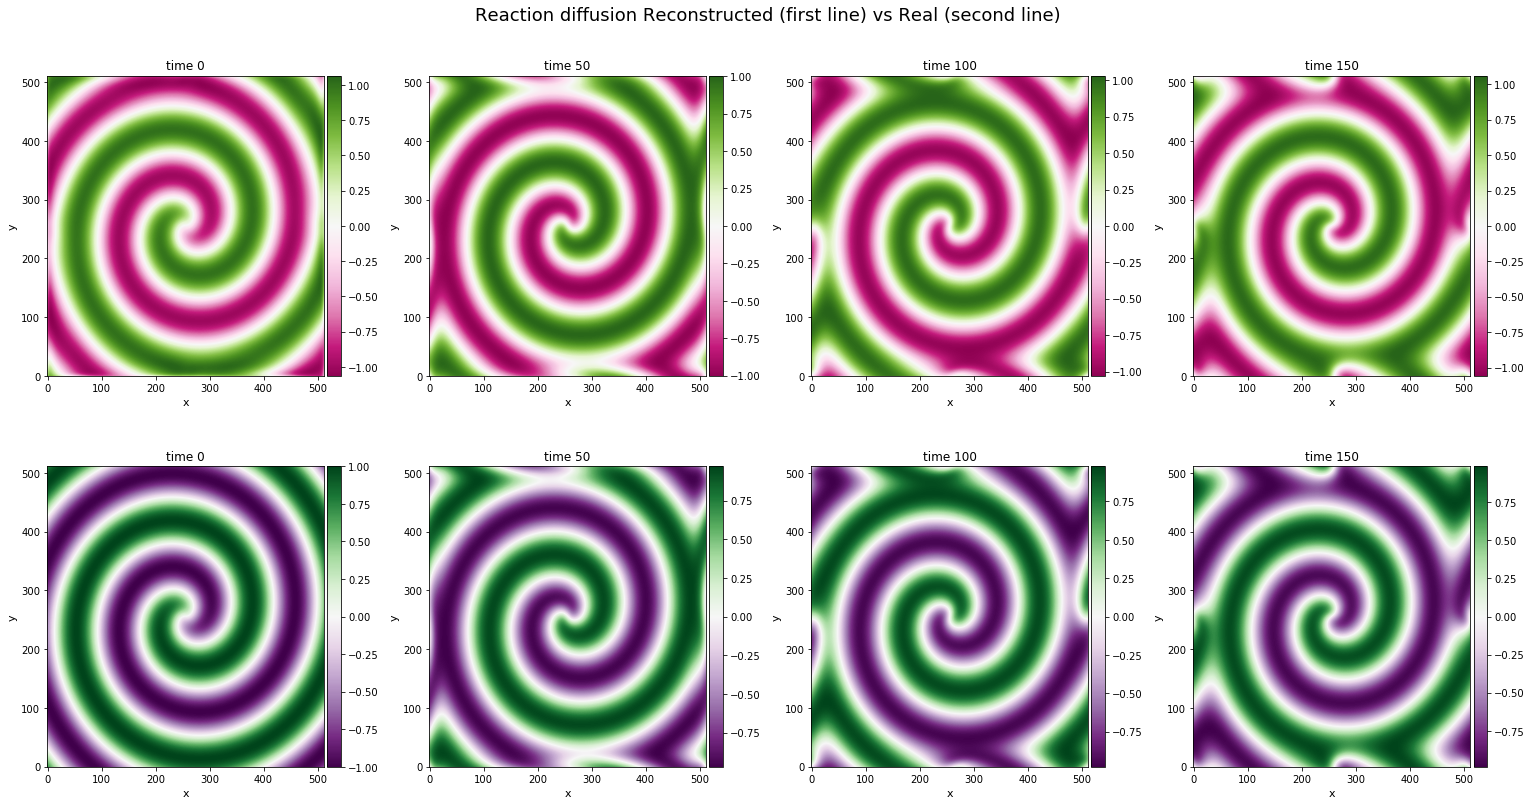

In [14]:

fig = plt.figure(figsize=(25, 12))
fig.suptitle("Reaction diffusion Reconstructed (first line) vs Real (second line)", fontsize=18)
gs = gridspec.GridSpec(2, 4)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)   
k = -1
j = 0


for _time in np.arange(0, 200, 50):

        
    ax = plt.subplot(gs[0, j%4])
    h = ax.imshow(reconstructed[:, :, _time], interpolation='lanczos', cmap='PiYG', 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % _time, fontsize = 12)

    ax = plt.subplot(gs[1, j%4])
    h = ax.imshow(V_original[:, :, _time], interpolation='lanczos', cmap='PRGn', 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % _time, fontsize = 12)

    
    j += 1

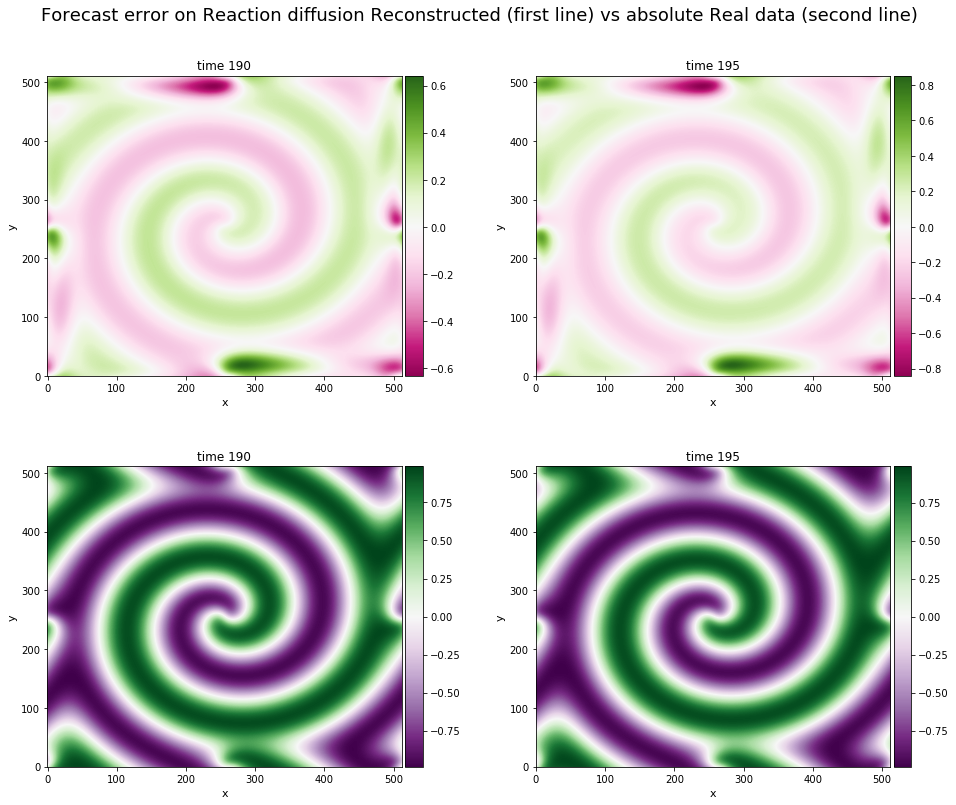

In [15]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle("Forecast error on Reaction diffusion Reconstructed (first line) vs absolute Real data (second line)", fontsize=18)
gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)   
k = -1
j = 0


for _time in np.arange(190, 199, 5):

        
    ax = plt.subplot(gs[0, j%4])
    h = ax.imshow((V_original[:, :, _time] - reconstructed[:, :, _time])/V_original.max(), interpolation='lanczos', cmap='PiYG', 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % _time, fontsize = 12)

    ax = plt.subplot(gs[1, j%4])
    h = ax.imshow(V_original[:, :, _time], interpolation='lanczos', cmap='PRGn', 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('x', fontsize = 11)
    ax.set_ylabel('y', fontsize = 11)
    ax.set_title('time %d' % _time, fontsize = 12)

    
    j += 1